<a href="https://colab.research.google.com/github/Saish31/AIML/blob/main/Unsupervised_Image_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install sentence_transformers

In [2]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import matplotlib.pyplot as plt
import glob
import torch
import os

In [ ]:
!wget https://public.ukp.informatik.tu-darmstadt.de/reimers/sentence-transformers/datasets/unsplash-25k-photos.zip

In [ ]:
!unzip 'unsplash-25k-photos.zip' -d 'photos'

In [5]:
img_names = list(glob.glob('photos/*.jpg'))[:2000]
print("Images:", len(img_names))

Images: 2000


In [ ]:
model = SentenceTransformer('clip-ViT-B-32')

In [8]:
img_embed = model.encode([Image.open(img) for img in img_names], batch_size=32, convert_to_tensor=True)

In [9]:
embeddings = img_embed
threshold = 0.8
min_community_size=5
init_max_size=1000

cos_scores = util.cos_sim(embeddings, embeddings)

In [10]:
cos_scores.shape

torch.Size([2000, 2000])

In [11]:
cos_scores

tensor([[1.0000, 0.5899, 0.6050,  ..., 0.6066, 0.5730, 0.5988],
        [0.5899, 1.0000, 0.6914,  ..., 0.6979, 0.6250, 0.6306],
        [0.6050, 0.6914, 1.0000,  ..., 0.8163, 0.7605, 0.7612],
        ...,
        [0.6066, 0.6979, 0.8163,  ..., 1.0000, 0.6927, 0.6770],
        [0.5730, 0.6250, 0.7605,  ..., 0.6927, 1.0000, 0.7949],
        [0.5988, 0.6306, 0.7612,  ..., 0.6770, 0.7949, 1.0000]])

In [12]:
top_k_values, _ = cos_scores.topk(k=min_community_size, largest=True)

In [13]:
top_k_values.shape

torch.Size([2000, 5])

In [14]:
extracted_communities = []
for i in range(len(top_k_values)):
  if top_k_values[i][-1] >= threshold:
    new_cluster = []

    top_val_large, top_idx_large = cos_scores[i].topk(k=init_max_size, largest=True)
    top_idx_large = top_idx_large.tolist()
    top_val_large = top_val_large.tolist()

    if top_val_large[-1] < threshold:
      for idx, val in zip(top_idx_large,top_val_large):
        if val<threshold:
          break

        new_cluster.append(idx)

    else:
      for idx,val in enumerate(cos_scores[i].tolist()):
        if val>=threshold:
          new_cluster.append(idx)


    extracted_communities.append(new_cluster)


extracted_communities = sorted(extracted_communities, key=lambda x: len(x), reverse=True)

In [15]:
len(extracted_communities)

1657

In [16]:
unique_communities = []
extracted_ids = set()

for community in extracted_communities:
  add_cluster = True
  for idx in community:
    if idx in extracted_ids:
      add_cluster = False
      break

  if add_cluster:
    unique_communities.append(community)
    for idx in community:
      extracted_ids.add(idx)

In [17]:
len(unique_communities)

27



Cluster Size:  583


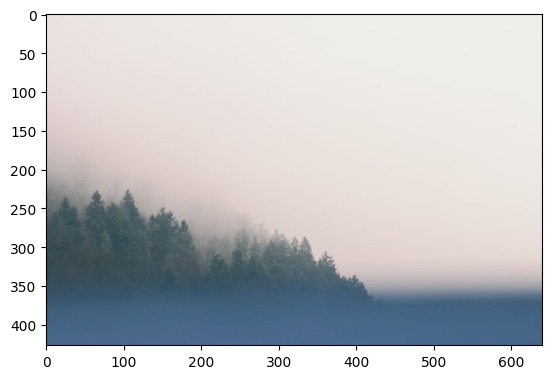

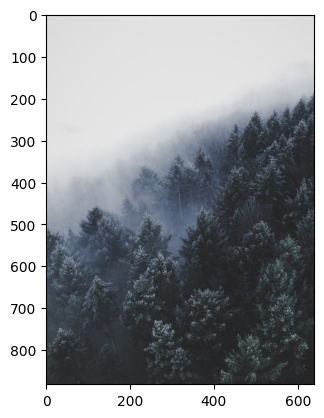

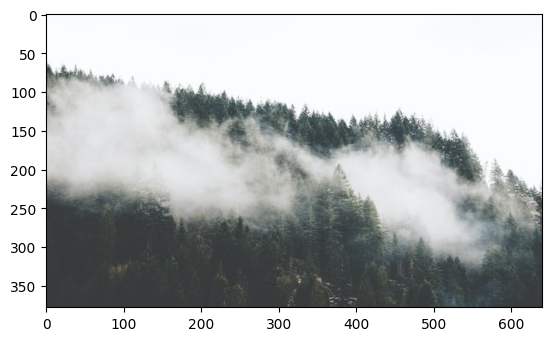



Cluster Size:  61


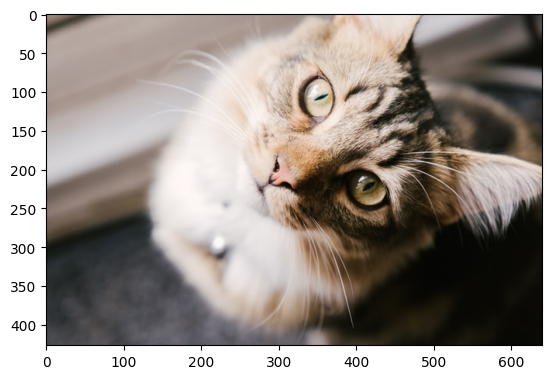

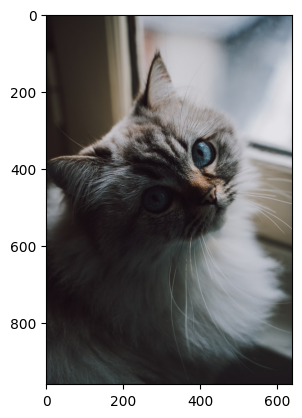

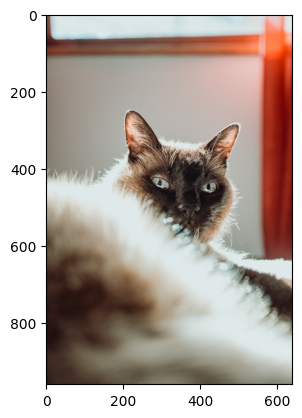



Cluster Size:  30


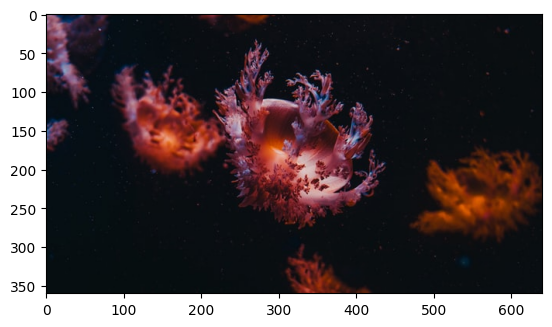

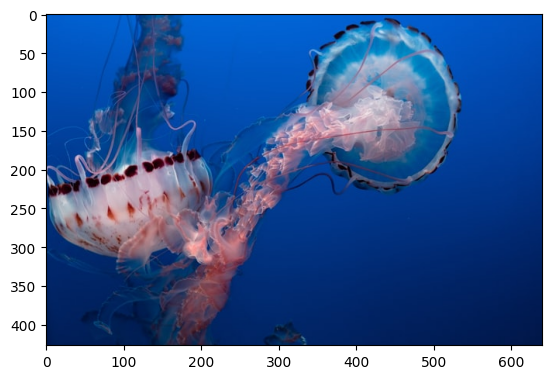

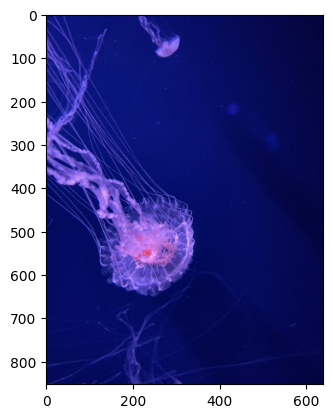

In [19]:
for cluster in unique_communities[0:3]:
  print("\n\nCluster Size: ", len(cluster))

  for idx in cluster[0:3]:
    img_path = img_names[idx]
    im = Image.open(img_path)
    plt.figure()
    plt.imshow(im)
    plt.show()